### [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb)'s YOLO V2 loss
<a data-flickr-embed="true"  href="https://www.flickr.com/photos/157237655@N08/45592720625/in/datetaken-public/" title="Screen Shot 2018-12-28 at 3.47.38 PM"><img src="https://farm8.staticflickr.com/7904/45592720625_821897e898_b.jpg" width="1024" height="570" alt="Screen Shot 2018-12-28 at 3.47.38 PM"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>


This is the third blog post of [Object Detection with YOLO blog series](https://fairyonice.github.io/tag/object-detection-using-yolov2-on-pascal-voc2012-series.html). This blog discusses the YOLO's model architecture and loss funciton. I will use PASCAL VOC2012 data. This blog assumes that the readers have read the previous two blog posts - [Part 1](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html), [Part 2](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html).


## Andrew Ng's Yolo lecture
- [Neural Networks - Bounding Box Predictions](https://www.youtube.com/watch?v=gKreZOUi-O0&t=0s&index=7&list=PL_IHmaMAvkVxdDOBRg2CbcJBq9SY7ZUvs)
- [C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE&t=7s)
- [C4W3L07 Nonmax Suppression](https://www.youtube.com/watch?v=VAo84c1hQX8&t=192s)
- [C4W3L08 Anchor Boxes](https://www.youtube.com/watch?v=RTlwl2bv0Tg&t=28s)
- [C4W3L09 YOLO Algorithm](https://www.youtube.com/watch?v=9s_FpMpdYW8&t=34s)


## Reference
- [You Only Look Once:Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf) 

- [YOLO9000:Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf)
 
- [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2)

## Reference in my blog
- [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html)

- [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html)

- [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model and loss](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2014_data_model_and_loss.html)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import tensorflow as tf
print(sys.version)
%matplotlib inline

3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## Define anchor box
<code>ANCHORS</code> defines the number of anchor boxes and the shape of each anchor box.
The choice of the anchor box specialization is already discussed in [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html). 

Based on the K-means analysis in the previous blog post, I will select 4 anchor boxes of following width and height. The width and heights are rescaled in the grid cell scale (Assuming that the number of grid size is 13 by 13.) See [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html) to learn how I rescal the anchor box shapes into the grid cell scale.

Here I choose 4 anchor boxes. With 13 by 13 grids, every frame gets 4 x 13 x 13 = 676 bouding box predictions.

In [10]:
ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

### Define Label vector containing 20 object classe names.

In [11]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

# YOLOv2's loss function
Before discussing the loss function, I will read in VOC2012 data, and call the batch generator in order to use the example batch <code> [x_batch,b_batch],y_batch</code> to demonstrate the usage of the loss funciton. 
### Read images and annotations into memory
Use the pre-processing code for parsing annotation at [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2).
This <code>parse_annoation</code> function is already used in [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html) and saved in my python script. 
This script can be downloaded at [my Github repository, FairyOnIce/ObjectDetectionYolo/backend](https://github.com/FairyOnIce/ObjectDetectionYolo/blob/master/backend.py).

In [12]:
### The location where the VOC2012 data is saved.
train_image_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/Annotations/"

np.random.seed(1)
from backend import parse_annotation
train_image, seen_train_labels = parse_annotation(train_annot_folder,
                                                  train_image_folder, 
                                                  labels=LABELS)
print("N train = {}".format(len(train_image)))


N train = 17125


### Instantiate batch generator object
<code>SimpleBatchGenerator</code> is discussed and used in 
[Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html).
This script can be downloaded at [my Github repository, FairyOnIce/ObjectDetectionYolo/backend](https://github.com/FairyOnIce/ObjectDetectionYolo/blob/master/backend.py).

In [13]:
from backend import SimpleBatchGenerator

BATCH_SIZE        = 200
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)
# CLASS             = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


def normalize(image):
    return image / 255.
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)

# Calculating YOLOv2's loss function
I have seen a lot of online blog posts about YOLO v1 loss function.
For example, at [Understanding YOLO](https://hackernoon.com/understanding-yolo-f5a74bbc7967).
However, most of these posts discusses the loss function of Yolo v1 which must be different from Yolo v2.
The two losses are different and the lack of explicit formula in the Yolo v2 loss paper rises some confusion, for example at [What is YOLOv2 Loss Function - Google Groups](https://groups.google.com/forum/#!topic/darknet/TJ4dN9R4iJk).


The YOLO v1 is difined in 
[You Only Look Once:Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf) as:

### YOLO V1 loss

$$\begin{array}{rl}
&\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
&+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
&+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
&+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
&+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{array}$$

YOLOv2 paper expalins the difference in architecture from YOLOv1 as follows:

<blockquote>
We remove the fully connected layers from YOLO(v1) and use anchor boxes to predict bounding boxes...
When we move to anchor boxes we also decouple the class prediction mechanism from the spatial location and instead predict class and objectness for every anchorbox. 
</blockquote>

This means that the confidence probability $p_i(c)$ above should depend not only on $i$ and $c$ but also an anchor box index, say $j$. Therefore, the loss needs to be different from above. Unfortunately, YOLOv2 paper does not explicitly state its loss function. So rather than making a guess based on the paper, I will try to understand the loss function that [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb) defines for his YOLOv2.

### [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb)'s YOLO V2 loss

In [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html), I showed that YOLO's output is encoded into <code>y_batch</code>.

Here I revisit YOLO's ground truth output encoding with mathematical notations.


<code>
y_batch
</code>

The numpy array of shape  <code>(BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) </code>.

BOX = The number of anchor boxes.

In the following notation, the grid cell index can be defined by two index (<code>igrid_h</code>,<code>igrid_w</code>) or by a single index $i$; (<code>igrid_h</code>,<code>igrid_w</code>) $\leftrightarrow i$

- <code>y_batch[iframe,igrid_h,igrid_w,j,:4]</code> contains <code>(center_x,center_y,center_w,center_h)</code> of <code>j</code>th anchor at <code>grid cell=(igrid_h,igrid_w)</code> = $i$, 
    if the object exists in this (grid cell, anchor) pair, else they simply contain 0.
    
    <code>y_batch[iframe,igrid_h,igrid_w,j,:4]</code>$= (x_{i,\texttt{j}},y_{i,\texttt{j}},w_{i,\texttt{j}},h_{i,\texttt{j}})$
    

- <code>y_batch[iframe,igrid_h,igrid_w,j,4]</code> 
    contains 1 if the object exists in this (grid cell, anchor) pair, else it contains 0.
    
     <code>y_batch[iframe,igrid_h,igrid_w,j,4]</code> = $ C_{i,\texttt{j}}$


- <code>y_batch[iframe,igrid_h,igrid_w,j,5 + iclass]</code> contains 1 if the <code>iclass</code>th class object exists in this (grid cell, anchor) pair, else it contains 0.

     <code>y_batch[iframe,igrid_h,igrid_w,j,5:]</code> $ = (p^1_{i,\texttt{j}},p^2_{i,\texttt{j}},p^3_{i,\texttt{j}},\cdots,p^{\textrm{Nclass}}_{i,\texttt{j}})$

The loss function of YOLO treats each set of elements 
<code>(center_x,center_y,center_w,center_h)</code>, 
<code>C</code>, and 
<code>(p_1,p_2,...p_Nclass)</code> in <code>y_batch[iframe,igrid_h,igrid_w,:]</code> differently. So let's understand each term of the loss one by one.


Then the loss corresponding to (grid cell, anchor box) pair = ($i,j$) is calculated as:

$$\small
%%%
\begin{array}{rl}\small
\textrm{loss}_{i,j} &= \textrm{loss}_{i,j}^{xywh} +  \textrm{loss}_{i,j}^p + \textrm{loss}_{i,j}^c \\
%%%
\textrm{loss}_{i,j}^{xywh}&=
\frac{\lambda_{\textrm{coord}}}{N_{L^{obj}}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\big[
\left(x_{i,j}-\hat{x}_{i,j}\right)^2 + 
\left(y_{i,j}-\hat{y}_{i,j}\right)^2 +\\
&\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\left(\sqrt{w}_{i,j}-\sqrt{\hat{w}}_{i,j}\right)^2 +
\left(\sqrt{h}_{i,j}-\sqrt{\hat{h}}_{i,j}\right)^2 
\big]\\
%%%
\textrm{loss}_{i,j}^p&=
-\frac{\lambda_{\text{class}}}{N_{L^{obj}}}
\sum_{i=0}^{S^2} \sum_{j=0}^B L_{i,j}^{\text{obj}}
\sum_{c \in \text{class}}  p_{i,j}^c \text{log}(\hat{p}_{i,j}^c)\\
%%%
\textrm{loss}_{i,j}^c &=
\frac{\lambda_{\text{obj}}}{N^{conf}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\left(
IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i,j}} - \widehat{C}_{i,j}
\right)^2\\
&\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;+
\frac{\lambda_{\textrm{noobj}}}{N^{conf}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{noobj}}
\left(0 - \widehat{C}_{i,j}\right)\\
\end{array}
$$


where: 
- $N_{L^{obj}} = \sum_{i=0}^{S^2}
\sum_{j=0}^B L_{i,j}^{\text{obj}}$
- $N^{conf} =  \sum_{i=0}^{S^2}
\sum_{j=0}^B L_{i,j}^{\text{obj}} + L_{i,j}^{\text{noobj}}(1-L_{i,j}^{\text{obj}})$

- $\text{preduiction}_{i,j}=(\hat{x}_{i,j},\hat{y}_{i,j},\hat{w}_{i,j},\hat{h}_{i,j})$
- $\text{ground truth}_{i,j}=(x_{i,j},y_{i,j},w_{i,j},h_{i,j})$
- $\lambda_{\text{coord}}$, $\lambda_{\text{class}}$ and $\lambda_{\text{noobj}}$ are scalars to weight each loss funciton 

Here, $L_{i,j}^{\text{noobj}}$ and $L_{i,j}^{\text{obj}}$ are 0/1 indicator function such that:
$$
\begin{array}{rl}
L_{i,j}^{\text{obj}}
 &= 
 \begin{cases}
 1 
\;\;\text{if} \;\;C_{i,j}=1\\
 0\;\;\text{else}\\
\end{cases}\\
L_{i,j}^{\text{noobj}}
& = 
\begin{cases}
 1 \;\;\text{if}\;\;\text{max}_{i',j'}
 \;\;IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i',j'}} < 0.6 \;\text{and}\; C_{i,j} = 0\\
 0\;\;\text{else}\\
\end{cases}\\
\end{array}
$$

As the loss function seems complex, let's go over the  [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb)'s YOLO V2 loss function line by line. 

### Global hyperparameters necessary for the loss function
 - BATCH_SIZE  
 - BOX 
 - CLASS_WEIGHTS
 - NO_OBJECT_SCALE
 - OBJECT_SCALE
 - LAMBDA_COORD
 - LAMBDA_CLASS
 - WEIGHT


In [14]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

### Step 1: Adjust prediction output 
[experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb)'s YOLO V2 loss function starts off by rescaling the prediction output. 
Notice that the predicted y_batch output can take any real values as the conv_23 layer has a linear activation function. However, the prediction outputs should be rescaled in the following range:


1. $\hat{x}_{i,j}$ ranges between [<code>igrid_w,igrid_w+1</code>).
2. $\hat{y}_{i,j}$ ranges between [<code>igrid_h,igrid_h+1</code>)
3. $\hat{w}_{i,j}$ ranges between 0, GRID_W
4. $\hat{h}_{i,j}$ ranges between 0, GRID_H
5. $\widehat{C}_{i,j}$ ranges between 0 and 1. 
6. $\widehat{p^c}_{i,j}$ ranges between 0 and 1

The 1, 2, 3 and 4 are because the bounding boxes are in grid cell scale. See Bounding box encoding Section in 
  [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html)

In [15]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output == 
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    '''
    ## cell_x.shape = (1, 13, 13, 1, 1)
    ## cell_x[:,i,j,:] = [[[j]]]
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    ## cell_y.shape = (1, 13, 13, 1, 1)
    ## cell_y[:,i,j,:] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    ## cell_gird.shape = (16, 13, 13, 5, 2)
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = j when k = 0
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = i when k = 1    
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid) 

def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    BOX = int(len(ANCHORS)/2)
    ## cell_grid is of the shape of 
    
    ### adjust x and y  
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
    ### adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh

    ### adjust confidence 
    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb

    ### adjust class probabilities 
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20
    
    return(pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)

#### Experiment <code>adjust_scale_prediction</code>

I generate the real valued y_pred before rescaling from Normal(mean=0,sd = const/(GRID_H*GRID_W)), as this will be my weight initializer for the layer 23 when const = 1. I will set const = 10 to make the distribution variance a bit larger. 

The bounding box parameters x, y, w, h and confidence are in the expected range. 
However, the class probabilities can take negative values. This is ok because the loss function later applies  softmax to <code>y_pred[:,:,:,:,5:]</code>.

In [16]:
def print_min_max(vec,title):
    print("{} MIN={:5.2f}, MAX={:5.2f}".format(
        title,np.min(vec),np.max(vec)))

print("*"*30)
print("prepare inputs")
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS)
print("y_pred before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
(pred_box_xy_tf,   pred_box_wh_tf, 
 pred_box_conf_tf, pred_box_class_tf) = adjust_scale_prediction(y_pred_tf, 
                                                                cell_grid, 
                                                                ANCHORS)
print("*"*30 + "\nouput\n" + "*"*30) 
with tf.Session() as sess:
    (pred_box_xy,   pred_box_wh, 
     pred_box_conf, pred_box_class) = sess.run(
        [pred_box_xy_tf,   pred_box_wh_tf,
         pred_box_conf_tf, pred_box_class_tf])
    
print("\npred_box_xy {}".format(pred_box_xy.shape))           
for igrid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,igrid_w,:,0].flatten(),
                      "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,igrid_h,:,:,1].flatten(),
                  "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,:,0].flatten(),"  bounding box width ") 
print_min_max(pred_box_wh[:,:,:,:,1].flatten(),"  bounding box height") 
    
print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf.flatten(),"  confidence ") 

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class.flatten(),"  class probability") 


******************************
prepare inputs
y_pred before scaling = (200, 13, 13, 4, 25)
******************************
define tensor graph
******************************
ouput
******************************

pred_box_xy (200, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.44, MAX= 0.55
  bounding box x at iGRID_W=01 MIN= 1.44, MAX= 1.55
  bounding box x at iGRID_W=02 MIN= 2.44, MAX= 2.56
  bounding box x at iGRID_W=03 MIN= 3.43, MAX= 3.56
  bounding box x at iGRID_W=04 MIN= 4.45, MAX= 4.56
  bounding box x at iGRID_W=05 MIN= 5.44, MAX= 5.56
  bounding box x at iGRID_W=06 MIN= 6.44, MAX= 6.56
  bounding box x at iGRID_W=07 MIN= 7.44, MAX= 7.56
  bounding box x at iGRID_W=08 MIN= 8.45, MAX= 8.56
  bounding box x at iGRID_W=09 MIN= 9.45, MAX= 9.55
  bounding box x at iGRID_W=10 MIN=10.45, MAX=10.55
  bounding box x at iGRID_W=11 MIN=11.45, MAX=11.56
  bounding box x at iGRID_W=12 MIN=12.44, MAX=12.56
  bounding box y at iGRID_H=00 MIN= 0.44, MAX= 0.56
  bounding box y at iGRID_H=0

### Step 2: Extract ground truth output
Extraction of the ground truth output is simpler than the extraction of the prediction output because the ground truth is already encoded in the correct scales. 

In [17]:
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

#### Experiment <code>extract_ground_truth</code>
The scales of the $C_{i,j}$ and ${p^c}_{i,j}$ are different from $\widehat{C}_{i,j}$ and $\widehat{p^c}_{i,j}$, as the their ground truths take 0/1 values: 
<table>
  <tr>
    <th></th>
    <th>Estimate</th>
    <th>Ground truth</th> 
    
  </tr>
  <tr>
    <th>$C_{i,j}$</th>
    <td>between 0 and 1 </td> 
    <td>1 (=an object exists) or 0</td>
  </tr>
  <tr>
    <td>$p^c_{i,j}$</td>
    <td>between 0 and 1</td> 
    <td>1 (=$c$th class object exists) or 0
    </td>
  </tr>
  <tr>
    <td></td>
    <td></td> 
    <td>later transfered to class index  $c$</td>
  </tr>  
</table>



When $C_{i,j}=1$, the scales of $x_{i,j}$, $y_{i,j}$, $w_{i,j}$, $h_{i,j}$ are the same as $\hat{x}_{i,j}$, $\hat{y}_{i,j}$, $\hat{w}_{i,j}$, $\hat{h}_{i,j}$.
When $C_{i,j}=0$, then all bounding box parameters $x_{i,j}$, $y_{i,j}$, $w_{i,j}$, $h_{i,j}$ takes zero values as no object exists for the (grid_cell, anchor) pair.


In [18]:
# y_batch is the output of the simpleBatchGenerator.fit()
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy_tf, true_box_wh_tf, 
 true_box_conf_tf, true_box_class_tf) = extract_ground_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

with tf.Session() as sess:
        (true_box_xy, true_box_wh, 
         true_box_conf, true_box_class) = sess.run(
                    [true_box_xy_tf,   true_box_wh_tf, 
                     true_box_conf_tf, true_box_class_tf])

print("\ntrue_box_xy {}".format(true_box_xy.shape))        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,igrid_w,:,0].flatten()
    pick = true_box_conf[:,:,igrid_w,:].flatten() == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    
for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,igrid_h,:,:,1].flatten()
    pick = true_box_conf[:,igrid_h,:,:].flatten() == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:,:,:,:,0].flatten(),"  bounding box width ") 
print_min_max(true_box_wh[:,:,:,:,1].flatten(),"  bounding box height") 
    
print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  confidence, unique value = {}".format(np.unique(true_box_conf.flatten()))) 

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class.flatten())) )


Input y_batch = (200, 13, 13, 4, 25)
******************************
ouput
******************************

true_box_xy (200, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.22, MAX= 0.97
  bounding box x at iGRID_W=01 MIN= 1.09, MAX= 1.73
  bounding box x at iGRID_W=02 MIN= 2.03, MAX= 2.95
  bounding box x at iGRID_W=03 MIN= 3.05, MAX= 3.94
  bounding box x at iGRID_W=04 MIN= 4.00, MAX= 4.98
  bounding box x at iGRID_W=05 MIN= 5.03, MAX= 5.98
  bounding box x at iGRID_W=06 MIN= 6.02, MAX= 6.97
  bounding box x at iGRID_W=07 MIN= 7.03, MAX= 7.95
  bounding box x at iGRID_W=08 MIN= 8.09, MAX= 8.98
  bounding box x at iGRID_W=09 MIN= 9.02, MAX= 9.95
  bounding box x at iGRID_W=10 MIN=10.03, MAX=10.92
  bounding box x at iGRID_W=11 MIN=11.06, MAX=11.95
  bounding box x at iGRID_W=12 MIN=12.08, MAX=12.88
  bounding box y at iGRID_H=00 MIN= 0.23, MAX= 0.59
  bounding box y at iGRID_H=01 MIN= 1.00, MAX= 1.48
  bounding box y at iGRID_H=02 MIN= 2.20, MAX= 2.59
  bounding box y at iGRID_H=03

### Step 3: calculate $\text{loss}_{i,j}^{xywh}$
Now we are ready to calculate the loss specific to the bounding box parameters. 

\begin{array}{rl}
\textrm{loss}_{i,j}^{xywh}&=
\frac{1}{N_{L^{obj}}}
\lambda_{\textrm{coord}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\big[
\left(x_{i,j}-\hat{x}_{i,j}\right)^2 + 
\left(y_{i,j}-\hat{y}_{i,j}\right)^2 +\\
&\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\left(\sqrt{w}_{i,j}-\sqrt{\hat{w}}_{i,j}\right)^2 +
\left(\sqrt{h}_{i,j}-\sqrt{\hat{h}}_{i,j}\right)^2 
\big]
\end{array}

In [19]:
def calc_loss_xywh(true_box_conf,
                   COORD_SCALE,
                   true_box_xy, pred_box_xy,true_box_wh,pred_box_wh):  
    '''
    coord_mask:      np.array of shape (Nbatch, Ngrid h, N grid w, N anchor, 1)
                     lambda_{coord} L_{i,j}^{obj}     
                         
    '''
    
    # lambda_{coord} L_{i,j}^{obj} 
    # np.array of shape (Nbatch, Ngrid h, N grid w, N anchor, 1)
    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * COORD_SCALE 
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    loss_xy      = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh      = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    return(loss_xy + loss_wh, coord_mask)


#### Experiment <code>calc_loss_xywh</code>

In [20]:
LAMBDA_COORD = 1
loss_xywh_tf, coord_mask_tf  = calc_loss_xywh(true_box_conf_tf,LAMBDA_COORD,
                                               true_box_xy_tf, pred_box_xy_tf,true_box_wh_tf,pred_box_wh_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

with tf.Session() as sess:
        loss_xywh = sess.run([loss_xywh_tf])[0]
print("loss_xywh = {:4.3f}".format(loss_xywh))

******************************
ouput
******************************
loss_xywh = 3.035


### Step 4: calculate $\text{loss}_{i,j}^{p}$
$$
\textrm{loss}_{i,j}^p=-\frac{1}{N_{L^{obj}}}
\lambda_{\text{class}}\sum_{i=0}^{S^2} \sum_{j=0}^B L_{i,j}^{\text{obj}}
\sum_{c \in \text{class}}  p_{i,j}^c \text{log}(\hat{p}_{i,j}^c)
$$

In [21]:
def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class):
    '''
    == input ==    
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0
    
    == output ==  
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    '''   
    class_mask   = true_box_conf  * CLASS_SCALE ## L_{i,j}^obj * lambda_class
    
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return(loss_class)


#Example useage of tf.gather
#indices = np.array([[0,0],
#                    [1,0],
#                    [0,1]])

#arr  = tf.constant(indices)
#temp = tf.gather(np.array([100,-20]), arr)
#with tf.Session() as sess:
#    t = sess.run(temp)
#print(t)

#[[100 100]
# [-20 100]
# [100 -20]]


#### Experiment <code>calc_loss_class</code>

In [22]:
LAMBDA_CLASS   = 1
loss_class_tf  = calc_loss_class(true_box_conf_tf,LAMBDA_CLASS,
                                 true_box_class_tf,pred_box_class_tf)
print("*"*30 + "\nouput\n" + "*"*30) 
with tf.Session() as sess:
        loss_class = sess.run(loss_class_tf)
print("loss_class = {:4.3f}".format(loss_class))

******************************
ouput
******************************
loss_class = 2.994


## $\textrm{loss}_{i,j}^c$
The rest of calculation is dedicated to evaluate confidence loss $\textrm{loss}_{i,j}^c$

$$
\textrm{loss}_{i,j}^c =\lambda_{\text{obj}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\left(
IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i,j}} - \widehat{C}_{i,j}
\right)^2+
\lambda_{\textrm{noobj}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{noobj}}
\left(0 - \widehat{C}_{i,j}\right)
$$

### Step 5, calculate $IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i,j}} $
For each (grid cell, anchor) pair, compute IOU between ground truth bounding box and predicted bounding box.
$IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i,j}} $ is 0 if $C_{i,j}=0$. 

In [23]:
def get_intersect_area(true_xy,true_wh,
                       pred_xy,pred_wh):
    '''
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
        
    '''
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf,
                                true_box_xy, true_box_wh,
                                pred_box_xy,  pred_box_wh):
    ''' 
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh,
                                            pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return(true_box_conf_IOU)

#### Experiment <code>calc_IOU_pred_true_assigned</code>

******************************
input
******************************
true_box_conf_tf = Tensor("strided_slice_6:0", shape=(200, 13, 13, 4), dtype=float32)
true_box_xy_tf   = Tensor("strided_slice_4:0", shape=(200, 13, 13, 4, 2), dtype=float32)
true_box_wh_tf   = Tensor("strided_slice_5:0", shape=(200, 13, 13, 4, 2), dtype=float32)
pred_box_xy_tf   = Tensor("add:0", shape=(200, 13, 13, 4, 2), dtype=float32)
pred_box_wh_tf   = Tensor("mul:0", shape=(200, 13, 13, 4, 2), dtype=float32)
******************************
ouput
******************************
true_box_conf_IOU.shape = (200, 13, 13, 4)


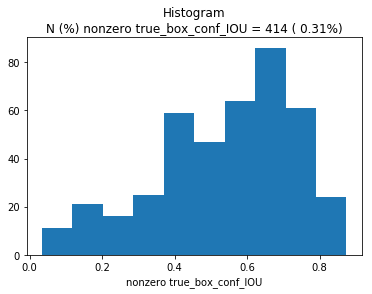

In [24]:
true_box_conf_IOU_tf = calc_IOU_pred_true_assigned(
                            true_box_conf_tf,
                            true_box_xy_tf, true_box_wh_tf,
                            pred_box_xy_tf,  pred_box_wh_tf)
with tf.Session() as sess:
    true_box_conf_IOU = sess.run(true_box_conf_IOU_tf)
print("*"*30 + "\ninput\n" + "*"*30)    
print("true_box_conf_tf = {}".format(true_box_conf_tf))
print("true_box_xy_tf   = {}".format(true_box_xy_tf))
print("true_box_wh_tf   = {}".format(true_box_wh_tf))
print("pred_box_xy_tf   = {}".format(pred_box_xy_tf))
print("pred_box_wh_tf   = {}".format(pred_box_wh_tf))
print("*"*30 + "\nouput\n" + "*"*30) 
print("true_box_conf_IOU.shape = {}".format(true_box_conf_IOU.shape))
vec  = true_box_conf_IOU.flatten()
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()

### Step 6: Calculate $\text{max}_{i',j'}
 \;\;IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i',j'}}$
 
For each predicted bounded box from (grid cell, anchor box), 
calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.

This calculation uses true_boxes tensor. 
This tensor corresponds to the input <code>b_batch</code> from SimpleBatchGenerator, which is already introduced in [Part 2](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html).

From the previous blog, I cite the <code>b_batch</code> description.

<code>
b_batch
</code>


The numpy array of shape <code>(BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)</code>.

- <code>b_batch[iframe,1,1,1,ibuffer,:]</code> 
    contains <code>ibuffer</code>th object's <code>(center_x,center_y,center_w,center_h)</code> in <code>iframe</code>th frame. 
    
- If <code>ibuffer</code> > N objects in <code>iframe</code>th frame, then the values are simply 0.

- <code>TRUE_BOX_BUFFER</code> has to be some large number, so that the frame with the biggest number of objects can also record all objects. 

- The order of the objects do not matter. 


In [25]:
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh) # (N batch, N grid_h, N grid_w, N anchor, 50)   

    best_ious = tf.reduce_max(iou_scores, axis=4) # (N batch, N grid_h, N grid_w, N anchor)
    return(best_ious)


#### Experiment <code>calc_IOU_pred_true_best</code>

******************************
input
******************************
true_box_wh_tf   = Tensor("strided_slice_5:0", shape=(200, 13, 13, 4, 2), dtype=float32)
pred_box_xy_tf   = Tensor("add:0", shape=(200, 13, 13, 4, 2), dtype=float32)
pred_box_wh_tf   = Tensor("mul:0", shape=(200, 13, 13, 4, 2), dtype=float32)
******************************
ouput
******************************
best_ious.shape = (200, 13, 13, 4)


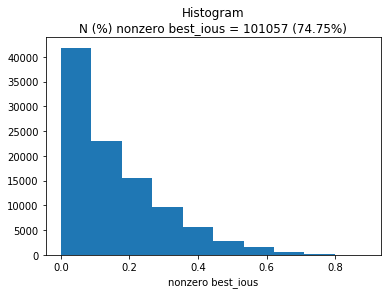

In [26]:
true_boxes_tf = tf.constant(b_batch,dtype="float32")
best_ious_tf = calc_IOU_pred_true_best(pred_box_xy_tf,
                                       pred_box_wh_tf,
                                       true_boxes_tf)
with tf.Session() as sess:
    best_ious = sess.run(best_ious_tf)
    
print("*"*30 + "\ninput\n" + "*"*30)    
print("true_box_wh_tf   = {}".format(true_box_wh_tf))
print("pred_box_xy_tf   = {}".format(pred_box_xy_tf))
print("pred_box_wh_tf   = {}".format(pred_box_wh_tf))
print("*"*30 + "\nouput\n" + "*"*30) 
print("best_ious.shape = {}".format(best_ious.shape))
vec  = best_ious.flatten()
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero best_ious")
plt.show()

### Step 7: Calculate $\lambda_{\text{noobj}}L_{i,j}^{\text{noobj}}$ and $\lambda_{\text{obj}}L_{i,j}^{\text{obj}}$
For each grid cell, calculate no object mask. 
$$
\begin{array}{rl}
L_{i,j}^{\text{noobj}}
& = 
\begin{cases}
 1 \;\;\text{if}\;\;\text{max}_{i',j'}
 \;\;IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i',j'}} < 0.6 \;\text{and}\; C_{i,j} = 0\\
 0\;\;\text{else}\\
\end{cases}
\end{array}
$$


In [27]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT):    
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair        
    '''

    conf_mask = tf.to_float(best_ious < 0.6) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return(conf_mask)

#### Experiment <code>get_conf_mask</code>

In [28]:
conf_mask_tf = get_conf_mask(best_ious_tf, 
                             true_box_conf_tf, 
                             true_box_conf_IOU_tf,
                             LAMBDA_NO_OBJECT, 
                             LAMBDA_OBJECT)
print("*"*30 + "\ninput\n" + "*"*30)  
print("best_ious         = {}".format(best_ious_tf)) 
print("true_box_conf     = {}".format(true_box_conf_tf))
print("true_box_conf_IOU = {}".format(true_box_conf_IOU_tf))
print("LAMBDA_NO_OBJECT  = {}".format(LAMBDA_NO_OBJECT)) 
print("LAMBDA_OBJECT     = {}".format(LAMBDA_OBJECT))
with tf.Session() as sess:
    conf_mask = sess.run(conf_mask_tf)
print("*"*30 + "\noutput\n" + "*"*30)      
print("conf_mask shape = {}".format(conf_mask.shape))


******************************
input
******************************
best_ious         = Tensor("Max:0", shape=(200, 13, 13, 4), dtype=float32)
true_box_conf     = Tensor("strided_slice_6:0", shape=(200, 13, 13, 4), dtype=float32)
true_box_conf_IOU = Tensor("mul_9:0", shape=(200, 13, 13, 4), dtype=float32)
LAMBDA_NO_OBJECT  = 1.0
LAMBDA_OBJECT     = 5.0
******************************
output
******************************
conf_mask shape = (200, 13, 13, 4)


### Step 8: Calculate loss for the confidence $\textrm{loss}_{i,j}^c$
$$
\textrm{loss}_{i,j}^c =
\frac{1}{N^{conf}}\left[
\lambda_{\text{obj}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\left(
IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i,j}} - \widehat{C}_{i,j}
\right)^2+
\lambda_{\textrm{noobj}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{noobj}}
\left(0 - \widehat{C}_{i,j}\right)
\right]
$$

- $N^{conf} =  \sum_{i=0}^{S^2}
\sum_{j=0}^B L_{i,j}^{\text{obj}} + L_{i,j}^{\text{noobj}}(1-L_{i,j}^{\text{obj}})$

In [29]:
def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  
    '''
    == input ==
    
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''
    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # N conf
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return(loss_conf)

### Experiment <code>calc_loss_conf</code>

In [30]:
print("*"*30 + "\ninput\n" + "*"*30)  
print("conf_mask_tf         = {}".format(conf_mask_tf)) 
print("true_box_conf_IOU_tf = {}".format(true_box_conf_IOU_tf))
print("pred_box_conf_tf     = {}".format(pred_box_conf_tf))

loss_conf_tf = calc_loss_conf(conf_mask_tf,true_box_conf_IOU_tf, pred_box_conf_tf)
with tf.Session() as sess:
    loss_conf = sess.run(loss_conf_tf) 
    
print("*"*30 + "\noutput\n" + "*"*30)      
print("loss_conf = {:5.4f}".format(loss_conf))

******************************
input
******************************
conf_mask_tf         = Tensor("add_11:0", shape=(200, 13, 13, 4), dtype=float32)
true_box_conf_IOU_tf = Tensor("mul_9:0", shape=(200, 13, 13, 4), dtype=float32)
pred_box_conf_tf     = Tensor("Sigmoid_1:0", shape=(200, 13, 13, 4), dtype=float32)
******************************
output
******************************
loss_conf = 0.1249


# <code>custom_loss(y_true,y_pred)</code>
Finally combine all the calculation above into <code>custom_loss(y_true,y_pred)</code>
Notice that true_boxes are tensor defined when the Keras model is declared. 
However, this tensor will not be passed as explicit arguments of the loss function.

In [31]:
def custom_loss(y_true, y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category <iclass> else 0
        
    '''
    total_recall = tf.Variable(0.)
    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    # Step 5: For each (grid cell, anchor) pair, 
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)

    
    loss = loss_xywh + loss_conf + loss_class
    

    
    return loss

### Experiment <code>custom_loss</code>

In [39]:
true_boxes = tf.Variable(np.zeros_like(b_batch),dtype="float32")
loss_tf    = custom_loss(y_batch_tf, y_pred_tf) 
with tf.Session() as sess:
    loss = sess.run(loss_tf,
                    feed_dict = {true_boxes: b_batch})
loss

6.1540704